In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white

from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split, cross_val_score


#Pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_theme(style="whitegrid")

In [3]:
#change directory for your path
os.chdir('E:\\OneDrive\\Documents\\GitHub\\eHealthEquity\\Research\\Data Source')

In [4]:
df = pd.read_csv('acs5y_2021_brfss_2021_merged.csv')

index_list = [
    'state','county'
]
brfss_list = [
    col for col in df.columns if col.startswith('brfss_') 
    and not col.endswith('crdprv') 
    and not col.endswith('upper') 
    and not col.endswith('lower')
]
acs_list = [
    col for col in df.columns if col.startswith('pct_')
]

all_columns = index_list + brfss_list + acs_list

df = df[all_columns]

In [5]:
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   state                       3076 non-null   object 
 1   county                      3076 non-null   object 
 2   brfss_access2_ageadjprv     3076 non-null   float64
 3   brfss_checkup_ageadjprv     3076 non-null   float64
 4   brfss_csmoking_ageadjprv    3076 non-null   float64
 5   brfss_depression_ageadjprv  3076 non-null   float64
 6   brfss_diabetes_ageadjprv    3076 non-null   float64
 7   brfss_ghlth_ageadjprv       3076 non-null   float64
 8   brfss_mhlth_ageadjprv       3076 non-null   float64
 9   brfss_obesity_ageadjprv     3076 non-null   float64
 10  pct_ed_lt9                  3076 non-null   float64
 11  pct_ed_9_12                 3076 non-null   float64
 12  pct_ed_hs                   3076 non-null   float64
 13  pct_ed_sc                   3076 

# Linear Regression Assumptions Check
## Linearity
Linearity between the dependent variable and the independent variables **PASS**

    * The relationship between the dependent variable and the independent variables is linear. See EDA for more details.
## Independence
No auto-correlation in the data (i.e. the data is not time-series data) **PASS** 

    * DW = 1.34
## No Multicollinearity
No or little multicollinearity between the independent variables **PASS** 

    * All features selected have a VIF < 5 
## Normality of Residuals
The residuals are normally distributed **PASS** 
    * QQ Plot: The residuals are normally distrubuted except for the tails. Not a severe violation. But worth noting.
    
## Homoscedasticity
Homoscedasticity  **PASS**
    * Residuals vs Fitted Plot: no clear pattern in the residuals vs fitted plot.

In [6]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]
covariates = [
    "brfss_access2_ageadjprv", # percentage of adults aged >=18 years who are unable to see a doctor in the past 12 months due to cost
    "brfss_checkup_ageadjprv", # percentage of adults aged >=18 years who had a checkup in the past 12 months
    #"brfss_csmoking_ageadjprv", # percentage of adults aged >=18 years who are current smokers
    "brfss_mhlth_ageadjprv", # percentage of adults aged >=18 years who report 14 or more days of poor mental health in the past 30 days
    "brfss_obesity_ageadjprv", # percentage of adults aged >=18 years who have obesity
    "pct_ed_lt9", # percentage of adults aged >=25 years with less than a 9th grade education
    "pct_ed_9_12", # percentage of adults aged >=25 years with a 9th to 12th grade education and no diploma
    "pct_ed_hs", # percentage of adults aged >=25 years with a high school diploma or GED
    #"pct_ed_sc", # percentage of adults aged >=25 years with some college (1-4 years)
    "pct_ed_asc", # percentage of adults aged >=25 years with an associate's degree
    #"pct_ed_b", # percentage of adults aged >=25 years with a bachelor's degree
    # "pct_ed_gr", # percentage of adults aged >=25 years with a graduate or professional degree
    "pct_age_gte65", # percentage of adults aged >=65 years
    "pct_occ_unemp", #  percentage of employed adults aged >=16 years who are unemployed
    # "pct_occ_mgt", # percentage of employed adults aged >=16 years who work in management, business, science, and arts occupations
    #"pct_occ_svc", # percentage of employed adults aged >=16 years who work in service occupations
    #"pct_occ_sales", # percentage of employed adults aged >=16 years who work in sales and office occupations
    # "pct_occ_nat_res", # percentage of employed adults aged >=16 years who work in natural resources, construction, and maintenance occupations
    # "pct_occ_prod", # percentage of employed adults aged >=16 years who work in production, transportation, and material moving occupations
    "pct_ses_pov",  # percentage of all people in poverty
    "pct_tp_veh_0", # percentage of households with zero vehicles
    # "pct_tp_veh_1", # percentage of households with one vehicle
    # "pct_tp_veh_2", # percentage of households with two vehicles
    # "pct_tp_veh_3" # percentage of households with three or more vehicles
]

# variables commented out due to high VIF values (>= 5)

X = df[iv + covariates]
y = df[dv]

features = "+".join(iv + covariates)
y, X = dmatrices(dv[0] + ' ~' + features, data=df, return_type='dataframe')

# Linear Regression and Assumptions Check

                     Results: Ordinary least squares
Model:              OLS                      Adj. R-squared:     0.905    
Dependent Variable: brfss_diabetes_ageadjprv AIC:                6520.7477
Date:               2023-11-08 05:37         BIC:                6605.1871
No. Observations:   3076                     Log-Likelihood:     -3246.4  
Df Model:           13                       F-statistic:        2256.    
Df Residuals:       3062                     Prob (F-statistic): 0.00     
R-squared:          0.905                    Scale:              0.48552  
--------------------------------------------------------------------------
                           Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  0.0203   0.3885   0.0522 0.9584 -0.7415  0.7820
pct_dg_bb_int             -0.0242   0.0026  -9.4776 0.0000 -0.0292 -0.0192
brfss_access2_ageadjprv    0.1105   0.0034  32.

,VIF,Tolerance,features
0,956.25,0.00,Intercept
1,2.57,0.39,pct_dg_bb_int
2,2.35,0.43,brfss_access2_ageadjprv
3,1.41,0.71,brfss_checkup_ageadjprv
4,3.18,0.31,brfss_mhlth_ageadjprv
5,2.49,0.40,brfss_obesity_ageadjprv
6,2.00,0.50,pct_ed_lt9
7,2.97,0.34,pct_ed_9_12
8,2.18,0.46,pct_ed_hs
9,1.51,0.66,pct_ed_asc


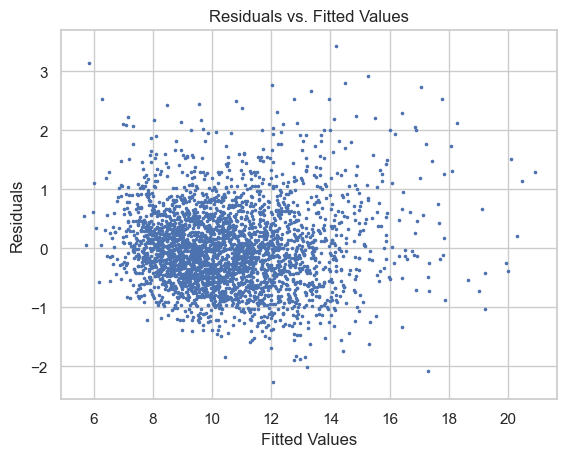

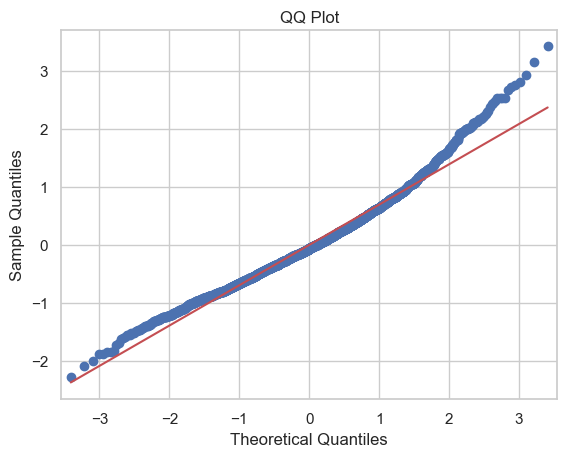

,MAE,RMSE,R2,Adj. R2,F-statistic,p-value,AIC,BIC,Log-Likelihood,n,k,df_resid,df_model
0,0.54,0.7,0.91,0.91,2255.74,0.0,6520.75,6605.19,-3246.37,3076.0,13.0,3062.0,13.0


,Chi^2,df,Prob > Chi^2
0,14237.63,13.0,0.0


In [15]:
model = smf.ols(formula=dv[0] + ' ~' + features, data=df)
results = model.fit()

#VIF
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns
#MAE
mae = np.mean(np.abs(results.resid))
rmse = np.sqrt(np.mean(results.resid**2))

#model summary
print(results.summary2())
print("MAE: ", mae)
display(vif.round(2))

#plot residuals
residuals = results.resid
plt.scatter(results.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#plot QQ with standardized line
sm.qqplot(residuals, line='s')
plt.title('QQ Plot')
plt.show()

#create model fit measures table
fit_measures = pd.DataFrame()
fit_measures['MAE'] = [mae]
fit_measures['RMSE'] = [rmse]
fit_measures['R2'] = [results.rsquared]
fit_measures['Adj. R2'] = [results.rsquared_adj]
fit_measures['F-statistic'] = [results.fvalue]
fit_measures['p-value'] = [results.f_pvalue]
fit_measures['AIC'] = [results.aic]
fit_measures['BIC'] = [results.bic]
fit_measures['Log-Likelihood'] = [results.llf]
fit_measures['n'] = [results.nobs]
fit_measures['k'] = [results.df_model]
fit_measures['df_resid'] = [results.df_resid]
fit_measures['df_model'] = [results.df_model]

display(fit_measures.round(2))

#create table forf Omnibus ANOVA test
omnibus = pd.DataFrame()
omnibus['Chi^2'] = [results.ess]
omnibus['df'] = [results.df_model]
omnibus['Prob > Chi^2'] = [results.f_pvalue]
display(omnibus.round(2))



pct_dg_bb_int (Broadband Internet access): The negative coefficient indicates that as broadband internet access increases, the age-adjusted diabetes prevalence decreases, holding all other factors constant.

Health-related variables (like brfss_access2_ageadjprv, brfss_checkup_ageadjprv, brfss_mhlth_ageadjprv, brfss_obesity_ageadjprv): Positive coefficients for these variables suggest that higher values in these health-related variables are associated with higher diabetes prevalence.

Educational variables (pct_ed_lt9, pct_ed_9_12, pct_ed_hs, pct_ed_asc): Varying signs on these coefficients indicate differing impacts of education levels on diabetes prevalence. For instance, having more of the population with less than a 9th-grade education (pct_ed_lt9) is associated with higher diabetes prevalence, while higher high school graduation rates (pct_ed_hs) are associated with lower prevalence.

pct_age_gte65 (Percentage of the population that is 65 or older): The negative coefficient suggests that areas with a higher percentage of older adults tend to have a lower diabetes prevalence when controlling for other factors.

pct_occ_unemp (Percentage of unemployed): The positive coefficient here indicates that higher unemployment is associated with higher diabetes prevalence.

pct_ses_pov (Percentage below poverty level): The positive coefficient indicates that higher poverty levels are associated with higher diabetes prevalence.

pct_tp_veh_0 (Percentage with no vehicle available): The positive coefficient suggests that having no vehicle available is associated with higher diabetes prevalence.

                      Results: Robust linear model
Model:                RLM                        Df Residuals:   3062   
Dependent Variable:   brfss_diabetes_ageadjprv   Norm:           HuberT 
Date:                 2023-11-08 05:58           Scale Est.:     mad    
No. Observations:     3076                       Cov. Type:      H1     
Df Model:             13                         Scale:          0.62696
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Intercept               -0.6626   0.3695  -1.7931 0.0730 -1.3869  0.0617
pct_dg_bb_int           -0.0217   0.0024  -8.9621 0.0000 -0.0265 -0.0170
brfss_access2_ageadjprv  0.1111   0.0032  34.2131 0.0000  0.1048  0.1175
brfss_checkup_ageadjprv  0.0653   0.0032  20.5097 0.0000  0.0591  0.0715
brfss_mhlth_ageadjprv    0.0877   0.0100   8.7628 0.0000  0.0681  0.1074


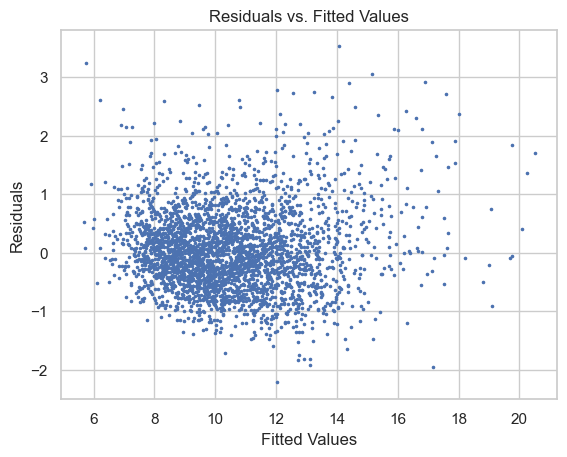

In [16]:
#Huber-White Robust Regression is robust to outliers and helps with heteroskedasticity

model = smf.rlm(formula=dv[0] + ' ~' + features, data=df, M=sm.robust.norms.HuberT())
results = model.fit()

print(results.summary2())

#plto residuals
residuals = results.resid
plt.scatter(results.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)


model = linear_model.LinearRegression()
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print("Cross-validated score:", scores)
y_pred = model.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:',  metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))
#heteroskedasticity
white_test = het_white(y_pred - y_test, X_test)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

#adjusted R2
n = X_test.shape[0]
p = X_test.shape[1]
r2 = metrics.r2_score(y_test, y_pred)
adj_r2 = 1 - ((1-r2)*(n-1)/(n-p-1))
print('Adjusted R2:', adj_r2)

#print coef and intercept with column names
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("Features:", X.columns)



Cross-validated score: [-0.59081046 -0.53093341 -0.51670749 -0.5025476  -0.60578077 -0.54164993
 -0.49968348 -0.51243829 -0.55103674 -0.54254861]
Mean Absolute Error: 0.5376756246461557
Mean Squared Error: 0.4756498945391838
Root Mean Squared Error: 0.689673759497332
R2: 0.9034825240058966
{'LM Statistic': 304.2359014070031, 'LM-Test p-value': 1.6286374380398651e-21, 'F-Statistic': 4.1793873979420795, 'F-Test p-value': 1.0201266097441919e-29}
Adjusted R2: 0.9016904223296135
Intercept: [0.13045777]
Coefficients: [[ 0.         -0.02713594  0.1118216   0.06215233  0.07352056  0.11859933
   0.01982076  0.07806667 -0.02685427 -0.02028363 -0.0358694   0.13090574
   0.11251503  0.02585381]]
Features: Index(['Intercept', 'pct_dg_bb_int', 'brfss_access2_ageadjprv',
       'brfss_checkup_ageadjprv', 'brfss_mhlth_ageadjprv',
       'brfss_obesity_ageadjprv', 'pct_ed_lt9', 'pct_ed_9_12', 'pct_ed_hs',
       'pct_ed_asc', 'pct_age_gte65', 'pct_occ_unemp', 'pct_ses_pov',
       'pct_tp_veh_0'],
    

In [11]:
model = linear_model.ElasticNet()
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print("Cross-validated score:", scores)
y_pred = model.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:',  metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))
#print coef and intercept with column names
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("Features:", X.columns)


Cross-validated score: [-0.64733932 -0.59539483 -0.54278736 -0.57671279 -0.67050093 -0.61494831
 -0.56621164 -0.5613878  -0.60443457 -0.57317676]
Mean Absolute Error: 0.5836427772174438
Mean Squared Error: 0.5630653393241263
Root Mean Squared Error: 0.7503767982314794
R2: 0.8857444393549612
Intercept: [1.64462417]
Coefficients: [ 0.         -0.01835271  0.11459959  0.04753114  0.          0.08757851
  0.0015031   0.06321161 -0.         -0.         -0.02846624  0.
  0.15399557  0.01868462]
Features: Index(['Intercept', 'pct_dg_bb_int', 'brfss_access2_ageadjprv',
       'brfss_checkup_ageadjprv', 'brfss_mhlth_ageadjprv',
       'brfss_obesity_ageadjprv', 'pct_ed_lt9', 'pct_ed_9_12', 'pct_ed_hs',
       'pct_ed_asc', 'pct_age_gte65', 'pct_occ_unemp', 'pct_ses_pov',
       'pct_tp_veh_0'],
      dtype='object')


Cross-validated score: [-0.59082157 -0.5309557  -0.51665635 -0.50248149 -0.60582073 -0.54166602
 -0.49961025 -0.51245535 -0.5509847  -0.54252773]
Mean Absolute Error: 0.5376748655509298
Mean Squared Error: 0.4756218668397798
Root Mean Squared Error: 0.6896534396635602
R2: 0.9034882113041288
Intercept: [0.13398874]
Coefficients: [[ 0.         -0.02713586  0.11179718  0.06214796  0.07341443  0.11856445
   0.01983492  0.07808082 -0.02683361 -0.02029853 -0.03588462  0.13053523
   0.11256318  0.02588005]]
Features: Index(['Intercept', 'pct_dg_bb_int', 'brfss_access2_ageadjprv',
       'brfss_checkup_ageadjprv', 'brfss_mhlth_ageadjprv',
       'brfss_obesity_ageadjprv', 'pct_ed_lt9', 'pct_ed_9_12', 'pct_ed_hs',
       'pct_ed_asc', 'pct_age_gte65', 'pct_occ_unemp', 'pct_ses_pov',
       'pct_tp_veh_0'],
      dtype='object')
{'LM Statistic': 304.0694901120615, 'LM-Test p-value': 1.7217031065628797e-21, 'F-Statistic': 4.175606253565824, 'F-Test p-value': 1.1175602761823387e-29}


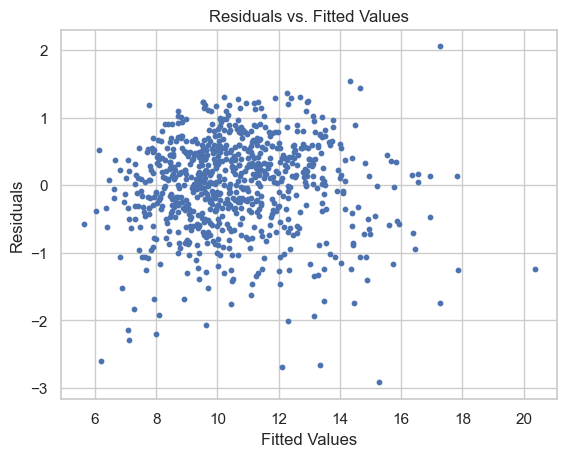

In [12]:
model = linear_model.Ridge(alpha=10)
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print("Cross-validated score:", scores)
y_pred = model.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:',  metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))
#print coef and intercept with column names
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("Features:", X.columns)
#plot residuals
residuals = y_pred - y_test
plt.scatter(y_pred, residuals, s=10)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
#test residuals for heteroskedasticity
white_test = het_white(residuals, X_test)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))
